# Demand forecasting with the Temporal Fusion Transformer

In [33]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths
%matplotlib inline
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet,TemporalFusionTransformer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE
import sys
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [11]:
def generateDummyData(peopleCount,numOfPersonas,strtDate,endDate,frequency):
    date_rng = pd.date_range(start=strtDate, end=endDate, freq=frequency)
    df = pd.DataFrame(date_rng, columns=['date'])

    for userNum in range(0, peopleCount):
        df['counter'] = range(1, 1 + len(df))           # Row ID
        df['userID'] = userNum                          # UserID

        userPersona = userNum%numOfPersonas+1
        #df ['amount'] = 1+(df['counter']%(userPersona+2)==0)*1
        df ['amount'] = 1+(df['counter']%(2)==0)*1

        if userNum == 0:
            finalDf = df.copy()  # Important - this is how you copy dataframes
        else:
            finalDf = finalDf.append(df, ignore_index=True)
    return finalDf

In [18]:
# Generate dummy data
data = generateDummyData(peopleCount=20,numOfPersonas=1,strtDate='1/1/18',endDate='31/12/21',frequency='d')

# add time index where 0 is the earliest date.
data["time_idx"] = data["date"].apply(pd.Timestamp.toordinal)
data["time_idx"] -= data["time_idx"].min()
data.head()

,date,counter,userID,amount,time_idx
0,2018-01-01,1,0,1,0
1,2018-01-02,2,0,2,1
2,2018-01-03,3,0,1,2
3,2018-01-04,4,0,2,3
4,2018-01-05,5,0,1,4


### Review dummy data

In [49]:
plt.show()
%matplotlib inline

<Figure size 1080x360 with 0 Axes>

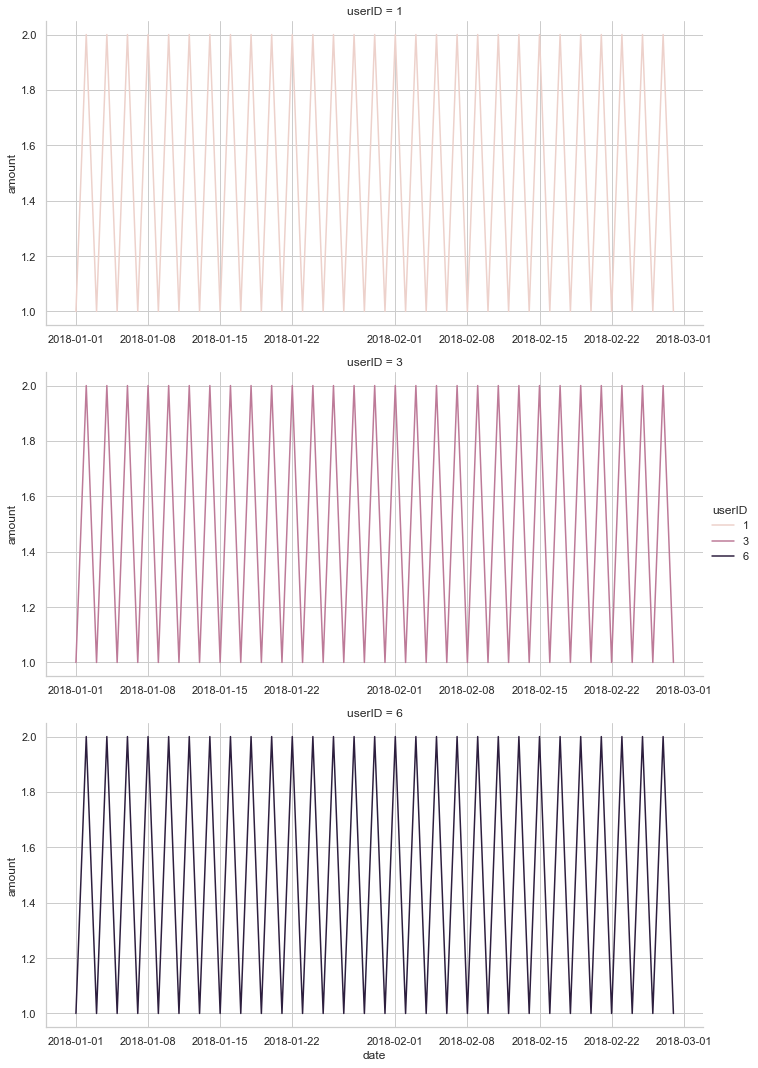

In [50]:
import seaborn as sns
plt.figure(figsize=(15,5))  # width and height
sns.set_theme(style="whitegrid")
palette = sns.color_palette("rocket_r")

# Plot the responses for different events and regions
df=data[(data['date']<='28/02/2018') & (data['userID'].isin([1, 3,6]))]  # Forgetting the brackets always trips me up!

g1 = sns.relplot(
    data=df,
    x="date", y="amount",
    hue="userID", col="userID",
    kind="line",
    height=5, aspect=2, facet_kws=dict(sharex=False), col_wrap=1, 
)

In [20]:
data['amount'] = data['amount'].astype(float)
data.dtypes

date        datetime64[ns]
counter              int64
userID               int64
amount             float64
time_idx             int64
dtype: object

In [21]:
# create dataset and dataloaders
max_encoder_length = 30
max_prediction_length = 7

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="amount",
    categorical_encoders={"userID": NaNLabelEncoder().fit(data.userID)},
    group_ids=["userID"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["amount"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [22]:
# Move column to the front - Inserted by me
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)

move_column_inplace(data,"time_idx",0)

In [23]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.3810)

In [24]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=1, gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[64, 512], backcast_loss_ratio=0.1)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [25]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42
Finding best initial lr: 100%|███████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.58it/s]


suggested learning rate: 0.0022387211385683386


In [38]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=20, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    weights_summary="full",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)


net = NBeats.from_dataset(
    training,
    learning_rate=0.002,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[64, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type                | Params
-----------------------------------------------------------------
0  | loss                    | MASE                | 0     
1  | logging_metrics         | ModuleList          | 0     
2  | logging_metrics.0       | SMAPE               | 0     
3  | logging_metrics.1       | MAE                 | 0     
4  | logging_metrics.2       | RMSE                | 0     
5  | logging_metrics.3       | MAPE                | 0     
6  | logging_metrics.4       | MASE                | 0     
7  | net_blocks              | ModuleList          | 1.7 M 
8  | net_blocks.0            | NBEATSTrendBlock    | 10.5 K
9  | net_blocks.0.fc         | Sequential          | 10.3 K
10 | net_blocks.0.fc.0       | Linear              | 2.0 K 
11 | net_blocks.0.fc.1       | ReLU                | 0     
12

Global seed set to 42


Epoch 0:  97%|████████████████████████████ | 30/31 [00:04<00:00,  6.76it/s, loss=0.484, v_num=6, train_loss_step=0.446]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|█████████████| 31/31 [00:04<00:00,  6.62it/s, loss=0.484, v_num=6, train_loss_step=0.446, val_loss=0.441]
Epoch 1:  97%|▉| 30/31 [00:04<00:00,  6.72it/s, loss=0.46, v_num=6, train_loss_step=0.438, val_loss=0.441, train_loss_e
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                                | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 31/31 [00:04<00:00,  6.56it/s, loss=0.46, v_num=6, train_loss_step=0.438, val_loss=0.432, train_loss_e
Epoch 2:  97%|▉| 30/31 [00:04<00:00,  6.57it/s, loss=0.448, v_num=6, train_loss_step=0.430, val_loss=0.432, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                                | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 31/31 [00:04<00:00,  6.42it/s, loss=0.448, v_num=6

Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                                | 0/1 [00:00<?, ?it/s]
Epoch 20: 100%|█| 31/31 [00:04<00:00,  6.90it/s, loss=0.442, v_num=6, train_loss_step=0.425, val_loss=0.427, train_loss
Epoch 21:  97%|▉| 30/31 [00:04<00:00,  7.04it/s, loss=0.441, v_num=6, train_loss_step=0.424, val_loss=0.427, train_loss
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                                | 0/1 [00:00<?, ?it/s]
Epoch 21: 100%|█| 31/31 [00:04<00:00,  6.86it/s, loss=0.441, v_num=6, train_loss_step=0.424, val_loss=0.428, train_loss
Epoch 22:  97%|▉| 30/31 [00:04<00:00,  6.81it/s, loss=0.441, v_num=6, train_loss_step=0.423, val_loss=0.428, train_loss
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                                | 0/1 [00:00<?, ?it/s]
Epoch 22: 100%|█| 31/31 [00:04<00:00,  6.67it/s, loss=0.441, v_num=

In [39]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [40]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.4157)

In [41]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

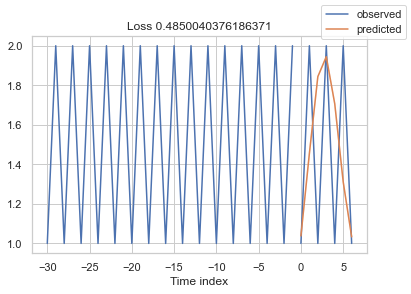

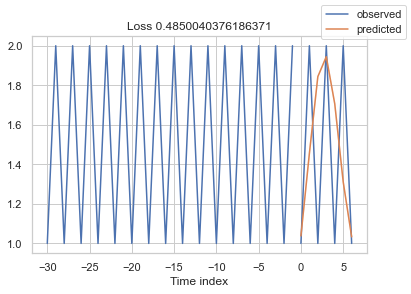

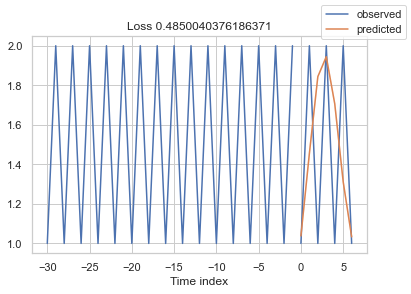

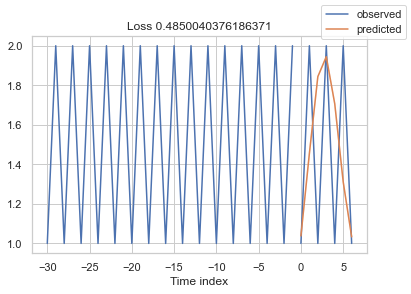

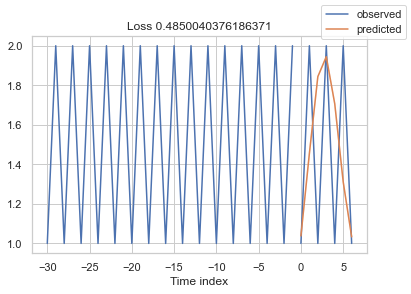

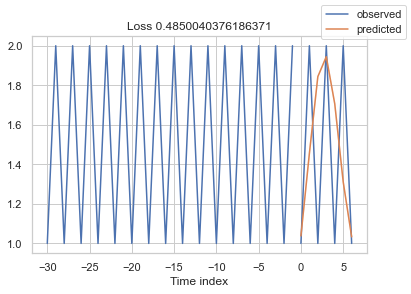

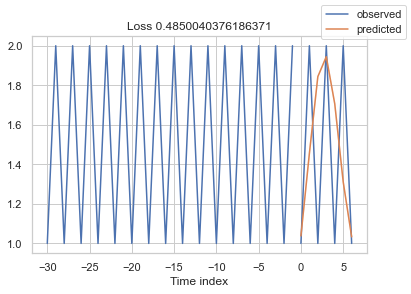

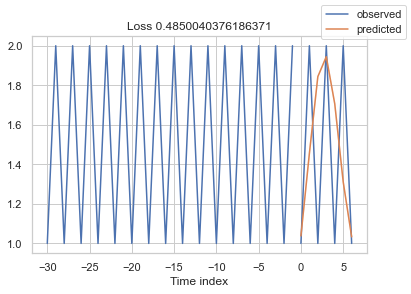

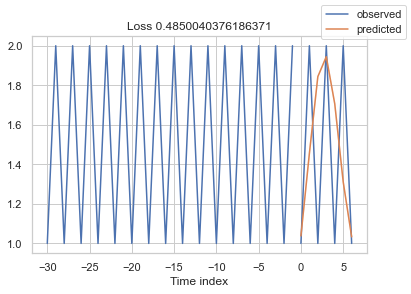

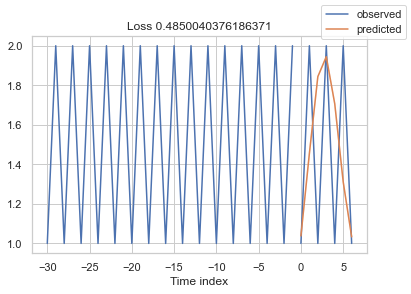

In [51]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [42]:
raw_predictions

Output(prediction=tensor([[1.0379, 1.4550, 1.8438, 1.9446, 1.7063, 1.3114, 1.0331],
        [1.0379, 1.4550, 1.8438, 1.9446, 1.7063, 1.3114, 1.0331],
        [1.0379, 1.4550, 1.8438, 1.9446, 1.7063, 1.3114, 1.0331],
        [1.0379, 1.4550, 1.8438, 1.9446, 1.7063, 1.3114, 1.0331],
        [1.0379, 1.4550, 1.8438, 1.9446, 1.7063, 1.3114, 1.0331],
        [1.0379, 1.4550, 1.8438, 1.9446, 1.7063, 1.3114, 1.0331],
        [1.0379, 1.4550, 1.8438, 1.9446, 1.7063, 1.3114, 1.0331],
        [1.0379, 1.4550, 1.8438, 1.9446, 1.7063, 1.3114, 1.0331],
        [1.0379, 1.4550, 1.8438, 1.9446, 1.7063, 1.3114, 1.0331],
        [1.0379, 1.4550, 1.8438, 1.9446, 1.7063, 1.3114, 1.0331],
        [1.0379, 1.4550, 1.8438, 1.9446, 1.7063, 1.3114, 1.0331],
        [1.0379, 1.4550, 1.8438, 1.9446, 1.7063, 1.3114, 1.0331],
        [1.0379, 1.4550, 1.8438, 1.9446, 1.7063, 1.3114, 1.0331],
        [1.0379, 1.4550, 1.8438, 1.9446, 1.7063, 1.3114, 1.0331],
        [1.0379, 1.4550, 1.8438, 1.9446, 1.7063, 1.3114, 1